In [ ]:
!pip install eli5
!pip install pdpbox
!pip install shap

In [ ]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from xgboost import XGBClassifier, plot_importance
import warnings
import eli5
import shap
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

In [ ]:
data = pd.read_csv('/content/heartu.csv')
# To display the top 5 rows
data.head(5)

age  sex  cp  trestbps  chol  ...  oldpeak  slope  ca  thal  condition
0   69    1   0       160   234  ...      0.1      1   1     0          0
1   69    0   0       140   239  ...      1.8      0   2     0          0
2   66    0   0       150   226  ...      2.6      2   0     0          0
3   65    1   0       138   282  ...      1.4      1   1     0          1
4   64    1   0       110   211  ...      1.8      1   0     0          0

[5 rows x 14 columns]

In [ ]:
data.describe()

age         sex          cp  ...          ca        thal   condition
count  297.000000  297.000000  297.000000  ...  297.000000  297.000000  297.000000
mean    54.542088    0.676768    2.158249  ...    0.676768    0.835017    0.461279
std      9.049736    0.468500    0.964859  ...    0.938965    0.956690    0.499340
min     29.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%     48.000000    0.000000    2.000000  ...    0.000000    0.000000    0.000000
50%     56.000000    1.000000    2.000000  ...    0.000000    0.000000    0.000000
75%     61.000000    1.000000    3.000000  ...    1.000000    2.000000    1.000000
max     77.000000    1.000000    3.000000  ...    3.000000    2.000000    1.000000

[8 rows x 14 columns]

In [ ]:
data.shape

(297, 14)

In [ ]:
heart = data.copy()

In [ ]:
target = 'condition'
features_list = list(heart.columns)
features_list.remove(target)

In [ ]:
y = heart.pop('condition')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(heart, y, test_size=0.2, random_state=33)
X_train.shape, X_test.shape

((237, 13), (60, 13))

In [ ]:
%%time

# ML in two lines ;)
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

CPU times: user 53.8 ms, sys: 4.65 ms, total: 58.4 ms
Wall time: 39.2 ms


In [ ]:
# make predictions for test data
xgb_predictions = xgb.predict(X_test)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
eli5.show_weights(xgb.get_booster(), top=15)

This diagram shows us the most important features of the dataset of Heart Disease. The three most important features are as follows:


1.   cp (Chest Pain Type) - There are four types of angina, depending on the number of symptoms the patient experiences.
  i. 0 - Typical Angina - Having all 3 major symptoms of Angina
  ii. 1 - Atypical Angina - Having 2 out of the 3 major symptoms of Angina
  iii. 2 - Non-Anginal Pain - Having one symptom
  iv. 3 - Asymptomatic 
  
  The severity of Angina is as follows:
  
  Typical Angina < Atypical Angina < Non-Anginal Pain < Asymptomatic
2.   thal (Thallium Test) - A thallium test is a test used to check how much blood is reaching different parts of the heart by using a radioactive tracer. They help the doctors to check the blood supply. 
  i. 0 - Normal results (no complications)
  ii. 1 - Fixed Defect - Blood supply is blocked at one or more parts of the heart
  iii. 2 - Reversible Defect - Blood supply is blocked at some parts, but it restributes after some time, hence, it's not permanent. 
3.   ca (Number of blocked vessels) - The heart has three main vessels for blood supply. By applying angiography, the doctor can see the results of how many vessels are blocked. 
  i. 0 - No vessels are blocked
  ii. 1 - 1 vessels are blocked
  iii. 2 - 2 vessels are blocked
  iv. 3 - 3 vessels are blocked


In [ ]:
tgt = 6
print('Reference:', y_test.iloc[tgt])
print('Predicted:', xgb_predictions[tgt])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[tgt], 
                     feature_names=list(heart.columns), show_feature_values=True)

Reference: 1
Predicted: 1


We have taken a local example here. We can see that the top 4 features contributing to the prediction of the feature are oldpeak, ca, cp and thal. 

Oldpeak, which is the most important feature in this prediction is related to the electrocardiograph results of the patient. If the electrocardiograph shows a ST Depression (indicating that the patient is suffering from myocardial ischaemia), the value of oldpeak shows us the level of the ST Depression. The more the depression, the likelier it is that the patient is suffering from heart disease. 

In [ ]:
%%time

# we need to retrain a new model with arrays
# as eli5 has a bug with Dataframes and XGBoost
# cf. https://github.com/TeamHG-Memex/eli5/pull/261
xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train.values, y_train)

CPU times: user 53.7 ms, sys: 3.06 ms, total: 56.7 ms
Wall time: 35.4 ms


In [ ]:
model = DecisionTreeClassifier(random_state=1)
model = model.fit(X_train, y_train)

In [ ]:
permutation = PermutationImportance(model, random_state=33).fit(X_train, y_train)

In [ ]:
eli5.show_weights(permutation, feature_names = features_list, top=30)

In [ ]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


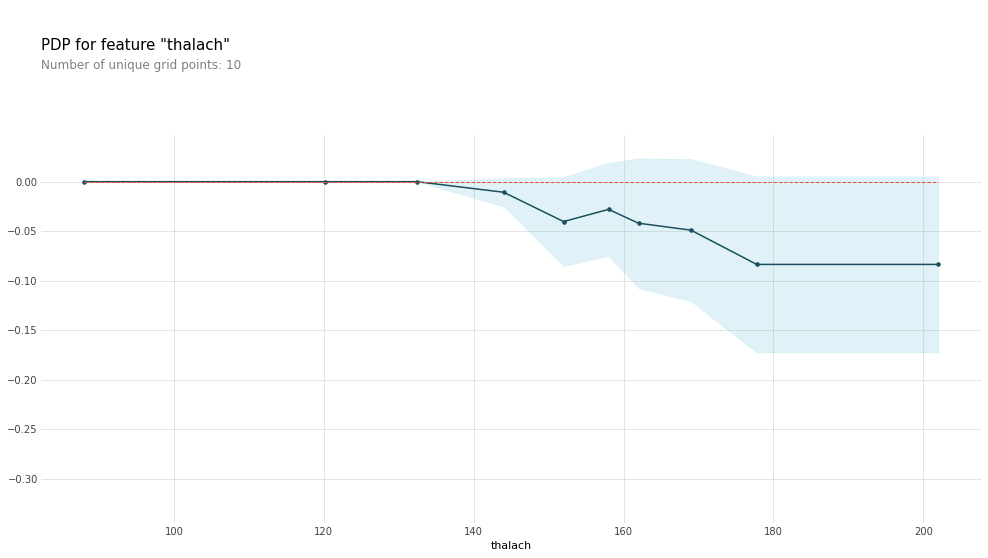

In [ ]:
plot_pdp(xgb, X_train, 'thalach')

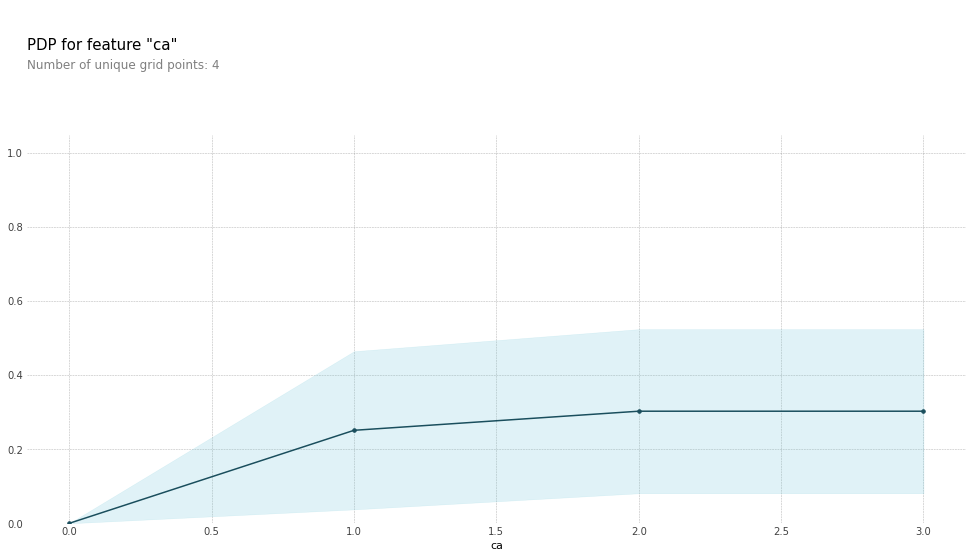

In [ ]:
plot_pdp(xgb, X_train, 'ca')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


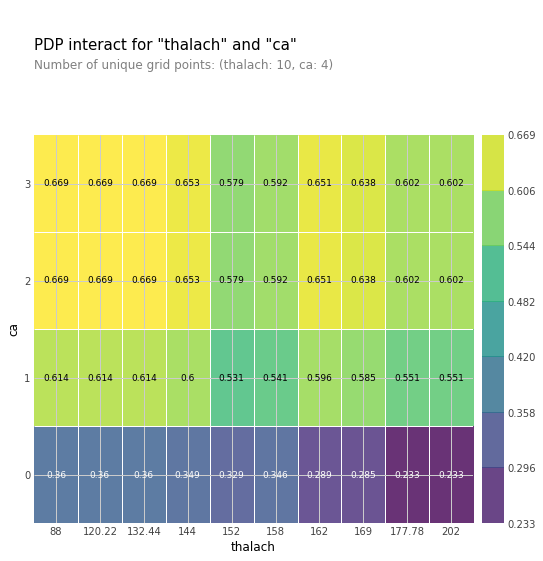

In [ ]:
features_to_plot = ['thalach', 'ca']
inter1  =  pdp.pdp_interact(model=xgb, dataset=X_train, model_features=features_list, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

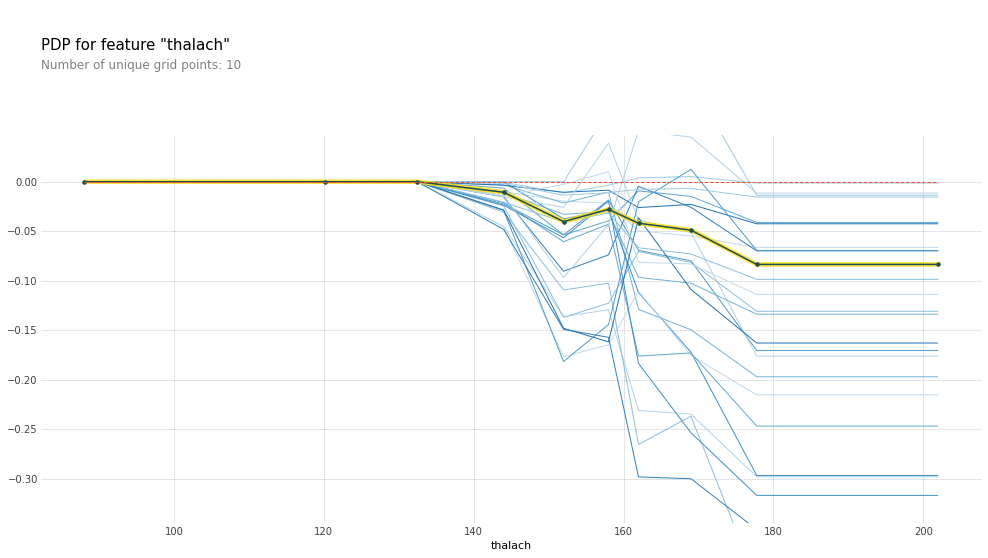

In [ ]:
plot_pdp(xgb, X_train, 'thalach', cluster_flag=True, nb_clusters=24, lines_flag=True)

In [ ]:
!pip install skater

In [ ]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [ ]:
interpreter = Interpretation(training_data=X_test, training_labels=y_test, feature_names=features_list)
im_model = InMemoryModel(xgb.predict_proba, examples=X_train, target_names=['Disease', 'No Disease'])

In [ ]:
predictions = xgb_array.predict_proba(X_test.values)


In [ ]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=features_list, discretize_continuous=True, class_names=['No disease', 'Disease'])

In [ ]:
tgt = 1
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 0
Predicted: [0.9808606 0.0191394]


We explain a local instance using LIME. The final prediction of the model is 0 (The patient is not suffering from heart disease). We can see the feature values that are contributing to this prediction of the model.

Looking at the top 3 features and explaining:
1. ca = 0. This shows that upon performing an angiography, no vessel of the heart was found to be blocked. This, of course, is wonderful as blocked vessels lead to a lack of blood flow and eventually problems (such as angina). The fact that no vessels are blocked is a great indicator of good health of the heart. 
2. thal = 0. Upon performing a Thallium test to check the blood flow in the heart, it is found that there are no defects and the results are normal.
3. cp = 2. This indicates that the patient is suffering from Non-Anginal pain, which is not as bad as asymptomatic pain. 

In [ ]:
tgt = 6
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [0.00328815 0.99671185]


Looking at another, opposite example here. The prediction made by the model is that the patient is suffering from heart disease. Looking at and understanding the top 3 feature values contributing to this prediction:
1. ca = 2. This shows that 2 vessels out of the 3 heart vessels are blocked. This is poor, and leads to an extreme lack of blood flow in and out of the heart. The chances of disease are high due to this.
2. thal = 2. It signifies that there were defects initially in the test and that the blood flow isn't at an optimum level. This is coungruent with the earlier factor of there being 2 vessels that are blocked. 
3. oldpeak = 2.80. The level of ST Depression in the electrocardiograph results is high. The more the depression in the ECG Graph, the more are the chances of the patient being diagnosed with a disease. 

In [ ]:
tgt = 15
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [0.1326462 0.8673538]


We have looked at two extreme cases. Now, let's look at a case where the model predicted that the patient is suffering from angina but the result is not as obvious. Looking at the top 3 features. 
1. ca = 0. This shows us that no vessels are blocked. This is a good sign, and leads the model to think that the patient does not have a heart disease. 
2. thal = 0. Acting against ca, thallium test shows us that there are some defects in the blood supply and heart cells of the patient. This is a great example that shows us that in real life, results are mixed more often than not. 
3. cp = 3. The patient is suffering from chest pain type 3 (asymptomatic pain). This sounds counter intuitive, but asymptomatic pain is actually the most severe out of all 4 possible chest pain types. So, this leads the model to making a prediction that the patient has a heart disease. 

In [ ]:
# pip install shap
import shap

# load JS visualization code to notebook
shap.initjs()

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [ ]:
X_shap = pd.DataFrame(shap_values)
X_shap.head()

0         1         2   ...        10        11        12
0  0.121952  0.269830  0.751951  ... -0.161049  0.638319  0.405999
1 -0.396403 -0.518684 -0.473904  ...  0.514736 -0.936237 -0.698419
2 -0.093382 -0.591746  0.734683  ...  0.361756  1.428389  0.839870
3 -0.077114  0.225338  0.594843  ...  0.385597  1.133304  0.859036
4  0.152304 -0.455424  0.764597  ...  0.325850  1.577539  0.588100

[5 rows x 13 columns]

In [ ]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  -0.39178318


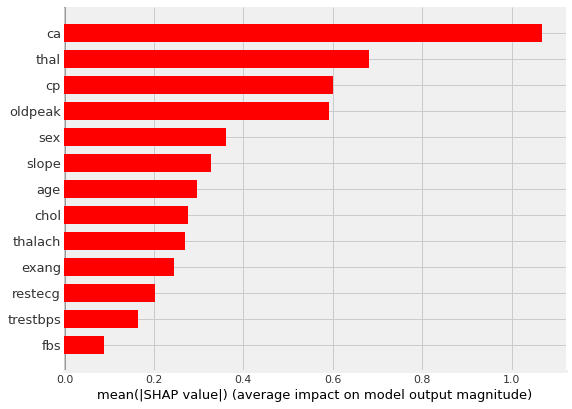

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')


Getting feature importance values using SHAP, we see similar results. ca, thal, cp and oldpeak are few of the most important features. 

We have explained the local instances using SHAP, similar to the LIME explanations, just visualised in a different way.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[6,:], X_test.iloc[6,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[15,:], X_test.iloc[15,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

This is a global explanation of the predictions of the model. -0.3918 is the base value as obtained using the SHAP Values. This means that if the total value is more than -0.3918, it signifies that the patient has the disease and if it is less than -0.3918, it signifies that the patient does not have the disease. The blue part of the graph pushes the prediction lower, and the red part is responsible for increasing it. This means that the instances in which there are a lot more red colored features will usually be 1 (having a disease) and vice versa.

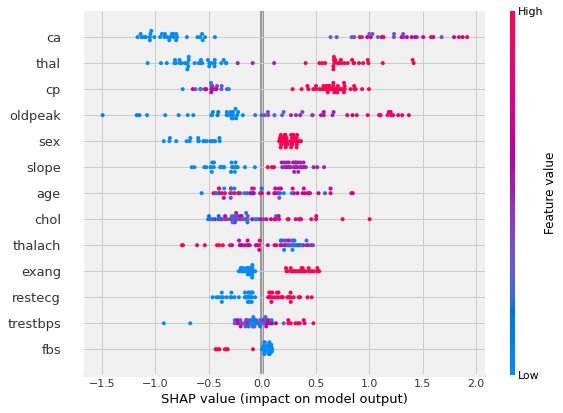

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

By this beautiful scatter plot graph, we have visualised the effects of the features on the prediction at different values. The color represents the value of the feature. (Blue meaning low, purple meaning the median value and red meaning high). For example, in ca, we see that when the dots are blue, the shap value is negative and when the dots are red and purple, the shap values are mostly positive. This signifies that when no vessels are blocked, chances of disease are low but as the number of vessels blocked increases, so does the chances of having a disease. 

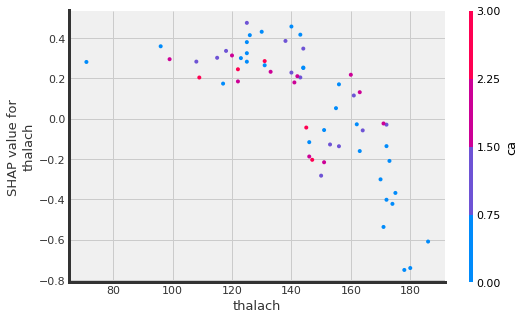

In [ ]:
shap.initjs()
shap.dependence_plot(ind='thalach', interaction_index='ca',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

This scatter plot shows us the relation between two features, as well as the SHAP Values. The X-axis shows us thalach (maximum heart rate), the Y-axis shows us the SHAP Values and the color of each dot shows us the value of ca. More often than not, the shap values are low when the value of ca is low. There is also a slight trend of the shap values decreasing as the value of thalach increases. 